In [ ]:
import pandas as pd

# Load the CSV file 
df = pd.read_csv("final_df.csv")

# Get number of columns
num_columns = len(df.columns)

# Get column names
column_names = df.columns.tolist()

# Print the results
print(f"🧾 Total columns: {num_columns}")
print("📋 Column names:")
for i, name in enumerate(column_names, start=1):
    print(f"{i}. {name}")


In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# === Step 1: Load your CSV ===
df = pd.read_csv("final_df.csv")

# === Step 2: Drop non-feature columns ===
non_features = ["UniProt ID", "Gene", "Mutation", "id", "WildType", "Mutant", "Neighbor_N", "Neighbor_C"]
df = df.drop(columns=[col for col in non_features if col in df.columns], errors="ignore")

# === Step 3: Encode class labels ===
le = LabelEncoder()
df["Class"] = le.fit_transform(df["Class"])  # Driver -> 1, Passenger -> 0

# === Step 4: Separate features and labels ===
# Drop label column
X = df.drop(columns=["Class"])

# Keeping only numeric columns
X = X.select_dtypes(include=["float64", "int64"])

y = df["Class"]

# === Step 5: Define the model ===
model = RandomForestClassifier(n_estimators=100, random_state=42)

# === Step 6: 10-fold cross-validation ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print(f"Average Accuracy (10-fold CV): {accuracy_scores.mean():.4f}")
print(f"All 10 Accuracies: {accuracy_scores}")

# === Step 7: Train and evaluate on the full dataset ===
model.fit(X, y)
y_pred = model.predict(X)
print("\n Classification Report (on full data):")
print(classification_report(y, y_pred))

Average Accuracy (10-fold CV): 0.6700
All 10 Accuracies: [0.67077268 0.67955182 0.66442577 0.67338936 0.66722689 0.66834734
 0.6605042  0.67114846 0.66106443 0.68403361]

 Classification Report (on full data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9253
           1       1.00      1.00      1.00      8598

    accuracy                           1.00     17851
   macro avg       1.00      1.00      1.00     17851
weighted avg       1.00      1.00      1.00     17851



In [2]:
pip install matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


==> Original test size: 3571
==> Filtered test size: 3374


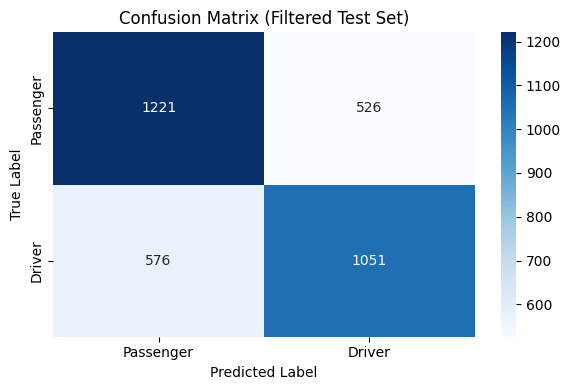

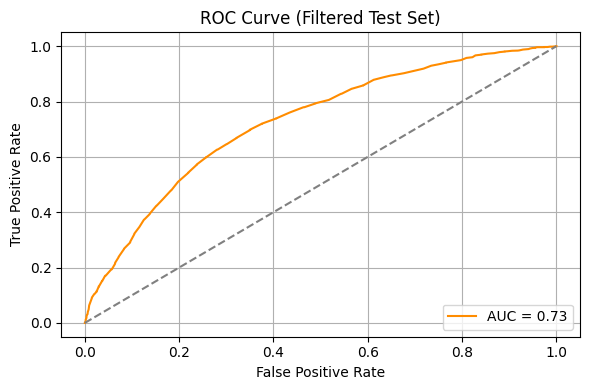

Classification Report on Filtered Test Set:
              precision    recall  f1-score   support

   Passenger       0.68      0.70      0.69      1747
      Driver       0.67      0.65      0.66      1627

    accuracy                           0.67      3374
   macro avg       0.67      0.67      0.67      3374
weighted avg       0.67      0.67      0.67      3374


 Random Forest Performance Metrics (Filtered Test Set):


,Metric,Value
0,Accuracy,0.673385
1,Sensitivity (Recall - Driver),0.645974
2,Specificity (Recall - Passenger),0.698912
3,Matthews Corr. Coefficient (MCC),0.345403
4,Area Under Curve (AUC),0.726200


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    matthews_corrcoef
)

# === Load dataset ===
df = pd.read_csv("final_df.csv")

# Drop unneeded columns
non_features = ["id", "WildType", "Mutant", "Neighbor_N", "Neighbor_C"]
df = df.drop(columns=[col for col in non_features if col in df.columns], errors="ignore")

# Encode target class
le = LabelEncoder()
df["Class"] = le.fit_transform(df["Class"])  # Driver -> 1, Passenger -> 0

# === Split into initial train/test ===
initial_train, initial_test = train_test_split(
    df, test_size=0.2, stratify=df["Class"], random_state=42
)

# === Filter test set to remove overlaps by (UniProt ID, Position) ===
train_sites = set(zip(initial_train["UniProt ID"], initial_train["Position"]))
filtered_test = initial_test[~initial_test.apply(
    lambda row: (row["UniProt ID"], row["Position"]) in train_sites, axis=1
)]

print(f"==> Original test size: {len(initial_test)}")
print(f"==> Filtered test size: {len(filtered_test)}")

# === Prepare features and labels ===
X_train = initial_train.drop(columns=["Class", "UniProt ID", "Gene", "Mutation"])
y_train = initial_train["Class"]

X_test = filtered_test.drop(columns=["Class", "UniProt ID", "Gene", "Mutation"])
y_test = filtered_test["Class"]

# Keep only numeric columns
X_train = X_train.select_dtypes(include=["float64", "int64"])
X_test = X_test.select_dtypes(include=["float64", "int64"])

# === Train Random Forest ===
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# === Predict on filtered test set ===
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# === 1. Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Passenger", "Driver"],
            yticklabels=["Passenger", "Driver"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Filtered Test Set)")
plt.tight_layout()
plt.show()

# === 2. ROC Curve + AUC ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Filtered Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 3. Classification Report ===
print("Classification Report on Filtered Test Set:")
print(classification_report(y_test, y_pred, target_names=["Passenger", "Driver"]))

# === 4. Calculate and Display Metrics Table ===
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
mcc = matthews_corrcoef(y_test, y_pred)

metrics = {
    "Accuracy": [accuracy],
    "Sensitivity (Recall - Driver)": [sensitivity],
    "Specificity (Recall - Passenger)": [specificity],
    "Matthews Corr. Coefficient (MCC)": [mcc],
    "Area Under Curve (AUC)": [roc_auc]
}

metrics_df = pd.DataFrame(metrics).T.reset_index()
metrics_df.columns = ["Metric", "Value"]
print("\n Random Forest Performance Metrics (Filtered Test Set):")
display(metrics_df)


In [4]:
pip install xgboost


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# Clean column names in both training and test sets for XGBoost compatibility
X_train.columns = X_train.columns.str.replace(r"[<>[\]]", "_", regex=True)
X_test.columns = X_test.columns.str.replace(r"[<>[\]]", "_", regex=True)

==> Original test size: 3571
==> Filtered test size: 3374


C:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:28:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


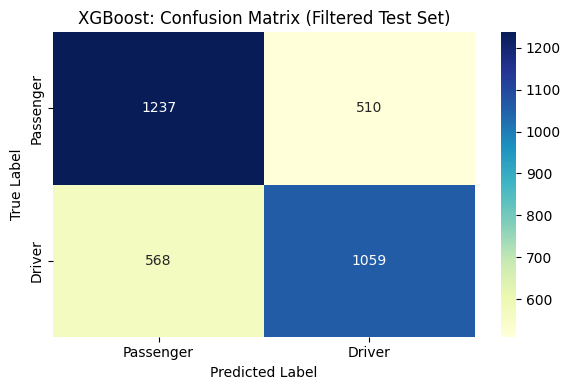

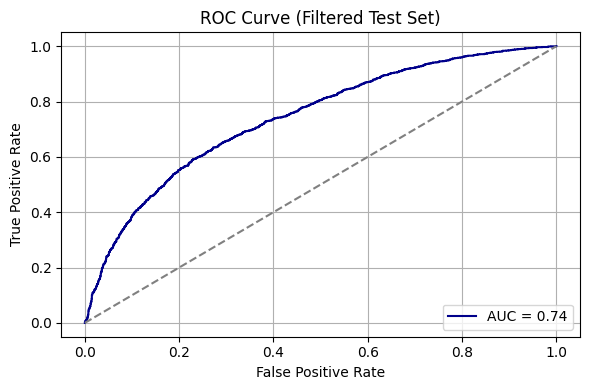

Classification Report (XGBoost on Filtered Test Set):
              precision    recall  f1-score   support

   Passenger       0.69      0.71      0.70      1747
      Driver       0.67      0.65      0.66      1627

    accuracy                           0.68      3374
   macro avg       0.68      0.68      0.68      3374
weighted avg       0.68      0.68      0.68      3374


 XGBoost Performance Metrics on Filtered Test Set:



,Metric,Value
0,Accuracy,0.6805
1,Sensitivity (Recall - Driver),0.6509
2,Specificity (Recall - Passenger),0.7081
3,Matthews Corr. Coefficient (MCC),0.3596
4,Area Under Curve (AUC),0.7415


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    matthews_corrcoef
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# === STEP 1: Load and prepare the data ===
df = pd.read_csv("final_df.csv")

# Drop unnecessary columns
non_features = ["id", "WildType", "Mutant", "Neighbor_N", "Neighbor_C"]
df = df.drop(columns=[col for col in non_features if col in df.columns], errors="ignore")

# Encode target class
le = LabelEncoder()
df["Class"] = le.fit_transform(df["Class"])  # Driver -> 1, Passenger -> 0

# === STEP 2: Split into initial train/test ===
initial_train, initial_test = train_test_split(
    df, test_size=0.2, stratify=df["Class"], random_state=42
)

# === STEP 3: Filter out test mutations at the same positions as training ===
train_sites = set(zip(initial_train["UniProt ID"], initial_train["Position"]))
filtered_test = initial_test[~initial_test.apply(
    lambda row: (row["UniProt ID"], row["Position"]) in train_sites,
    axis=1
)]

print(f"==> Original test size: {len(initial_test)}")
print(f"==> Filtered test size: {len(filtered_test)}")

# === STEP 4: Prepare features ===
# Define label and feature columns
X_train = initial_train.drop(columns=["Class", "UniProt ID", "Gene", "Mutation"])
y_train = initial_train["Class"]

X_test = filtered_test.drop(columns=["Class", "UniProt ID", "Gene", "Mutation"])
y_test = filtered_test["Class"]

# Keep numeric only
X_train = X_train.select_dtypes(include=["float64", "int64"])
X_test = X_test.select_dtypes(include=["float64", "int64"])

# Clean column names for XGBoost
X_train.columns = X_train.columns.str.replace(r"[<>[\]]", "_", regex=True)
X_test.columns = X_test.columns.str.replace(r"[<>[\]]", "_", regex=True)

# === STEP 5: Train XGBoost ===
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)
xgb_model.fit(X_train, y_train)

# === STEP 6: Predict and evaluate ===
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# === Confusion Matrix ===
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=["Passenger", "Driver"],
            yticklabels=["Passenger", "Driver"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost: Confusion Matrix (Filtered Test Set)")
plt.tight_layout()
plt.show()

# === ROC Curve ===
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(6, 4))
plt.plot(fpr_xgb, tpr_xgb, color="darkblue", label=f"AUC = {roc_auc_xgb:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Filtered Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Classification Report ===
print("Classification Report (XGBoost on Filtered Test Set):")
print(classification_report(y_test, y_pred_xgb, target_names=["Passenger", "Driver"]))

# === Metrics Table ===
tn, fp, fn, tp = cm_xgb.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
mcc = matthews_corrcoef(y_test, y_pred_xgb)

metrics_xgb = {
    "Accuracy": [f"{accuracy:.4f}"],
    "Sensitivity (Recall - Driver)": [f"{sensitivity:.4f}"],
    "Specificity (Recall - Passenger)": [f"{specificity:.4f}"],
    "Matthews Corr. Coefficient (MCC)": [f"{mcc:.4f}"],
    "Area Under Curve (AUC)": [f"{roc_auc_xgb:.4f}"]
}

df_metrics_xgb = pd.DataFrame(metrics_xgb).T.reset_index()
df_metrics_xgb.columns = ["Metric", "Value"]

print("\n XGBoost Performance Metrics on Filtered Test Set:\n")
display(df_metrics_xgb)


==> Original test size: 3571
==> Filtered test size: 3374
Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:37:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


==> Best Parameters:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}


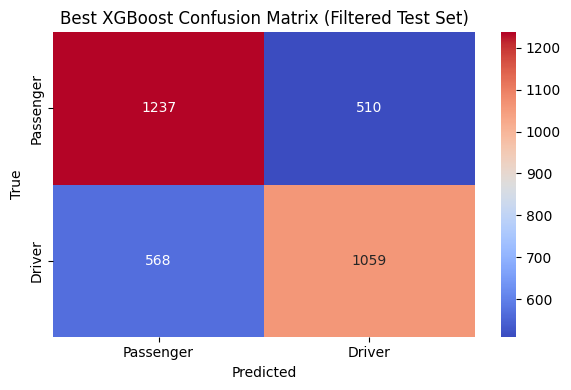

Classification Report (Best XGBoost - Filtered Test Set):
              precision    recall  f1-score   support

   Passenger       0.69      0.71      0.70      1747
      Driver       0.67      0.65      0.66      1627

    accuracy                           0.68      3374
   macro avg       0.68      0.68      0.68      3374
weighted avg       0.68      0.68      0.68      3374



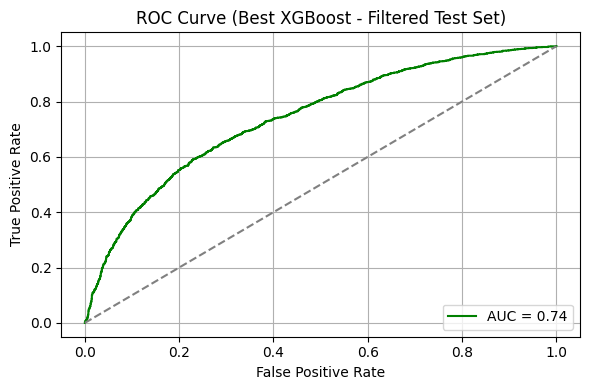


 Best XGBoost Metrics (Filtered Test Set):



,Metric,Value
0,Accuracy,0.680498
1,Sensitivity (Recall - Driver),0.650891
2,Specificity (Recall - Passenger),0.708071
3,Matthews Corr. Coefficient (MCC),0.359616
4,Area Under Curve (AUC),0.741523


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    make_scorer,
    recall_score,
    confusion_matrix,
    roc_curve,
    auc,
    matthews_corrcoef
)

# === Step 1: Load and prepare data ===
df = pd.read_csv("final_df.csv")

# Drop unnecessary columns
non_features = ["id", "WildType", "Mutant", "Neighbor_N", "Neighbor_C"]
df = df.drop(columns=[col for col in non_features if col in df.columns], errors="ignore")

# Encode class labels
le = LabelEncoder()
df["Class"] = le.fit_transform(df["Class"])  # Driver -> 1, Passenger -> 0

# === Step 2: Split data ===
initial_train, initial_test = train_test_split(
    df, test_size=0.2, stratify=df["Class"], random_state=42
)

# === Step 3: Filter test set to remove mutations at the same (UniProt ID, Position) as in train ===
train_sites = set(zip(initial_train["UniProt ID"], initial_train["Position"]))
filtered_test = initial_test[~initial_test.apply(
    lambda row: (row["UniProt ID"], row["Position"]) in train_sites,
    axis=1
)]

print(f"==> Original test size: {len(initial_test)}")
print(f"==> Filtered test size: {len(filtered_test)}")

# === Step 4: Prepare features ===
X_train = initial_train.drop(columns=["Class", "UniProt ID", "Gene", "Mutation"])
y_train = initial_train["Class"]

X_test = filtered_test.drop(columns=["Class", "UniProt ID", "Gene", "Mutation"])
y_test = filtered_test["Class"]

# Keep numeric features
X_train = X_train.select_dtypes(include=["float64", "int64"])
X_test = X_test.select_dtypes(include=["float64", "int64"])

# Clean column names for XGBoost
X_train.columns = X_train.columns.astype(str).str.replace(r"[<>[\]]", "_", regex=True)
X_test.columns = X_test.columns.astype(str).str.replace(r"[<>[\]]", "_", regex=True)

# === Step 5: Set up GridSearchCV ===
recall_driver = make_scorer(recall_score, pos_label=1)

param_grid = {
    'max_depth': [4, 6],
    'learning_rate': [0.1],
    'n_estimators': [100],
    'subsample': [1.0],
    'colsample_bytree': [1.0],
    'gamma': [0]
}

xgb_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring=recall_driver,
    cv=5,
    verbose=2,
    n_jobs=-1
)

# === Step 6: Fit best model ===
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("==> Best Parameters:")
print(grid_search.best_params_)

# === Step 7: Evaluate on filtered test set ===
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

# === Confusion Matrix ===
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="coolwarm",
            xticklabels=["Passenger", "Driver"],
            yticklabels=["Passenger", "Driver"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Best XGBoost Confusion Matrix (Filtered Test Set)")
plt.tight_layout()
plt.show()

# === Classification Report ===
print("Classification Report (Best XGBoost - Filtered Test Set):")
print(classification_report(y_test, y_pred_best, target_names=["Passenger", "Driver"]))

# === ROC Curve ===
fpr_best, tpr_best, _ = roc_curve(y_test, y_proba_best)
roc_auc_best = auc(fpr_best, tpr_best)

plt.figure(figsize=(6, 4))
plt.plot(fpr_best, tpr_best, label=f"AUC = {roc_auc_best:.2f}", color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Best XGBoost - Filtered Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Metrics Table ===
tn, fp, fn, tp = cm_best.ravel()
accuracy_best = (tp + tn) / (tp + tn + fp + fn)
sensitivity_best = tp / (tp + fn)
specificity_best = tn / (tn + fp)
mcc_best = matthews_corrcoef(y_test, y_pred_best)

metrics_best = {
    "Accuracy": [accuracy_best],
    "Sensitivity (Recall - Driver)": [sensitivity_best],
    "Specificity (Recall - Passenger)": [specificity_best],
    "Matthews Corr. Coefficient (MCC)": [mcc_best],
    "Area Under Curve (AUC)": [roc_auc_best]
}

df_metrics_best = pd.DataFrame(metrics_best).T.reset_index()
df_metrics_best.columns = ["Metric", "Value"]

# Display metrics as a DataFrame
print("\n Best XGBoost Metrics (Filtered Test Set):\n")
display(df_metrics_best)
